In [2]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit,transpile, QuantumRegister, ClassicalRegister
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit_aer import AerSimulator
from qiskit import BasicAer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
# qiskit-ibmq-provider has been deprecated.
# Please see the Migration Guides in https://ibm.biz/provider_migration_guide for more detail.
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options

# Loading your IBM Quantum account(s)
service = QiskitRuntimeService(channel="ibm_quantum")
from qiskit.circuit import ParameterVector


# Invoke a primitive inside a session. For more details see https://qiskit.org/documentation/partners/qiskit_ibm_runtime/tutorials.html
# with Session(backend=service.backend("ibmq_qasm_simulator")):
#     result = Sampler().run(circuits).result()

In [3]:
def angles(counter): # crowd size to angle mapper
    thetas = np.zeros(N)
    for k,v in counter.items():
        thetas[int(k)] = np.pi/(n*v)

    return thetas

# Iterative throw/days simulation 

In [4]:
###### Estimting number of Qubits required ###########

N = 8  # number of balls and number of buckets 
n = len(format(N-1,'b')) # number of qubits per ball/bucket

print(N*n,"qubits required")

24 qubits required


In [5]:
# ######### Building the KPR Problem Circuit #############

# qreg = QuantumRegister(N*n)
# circuit = QuantumCircuit(qreg)


# circuit.h(range(len(qreg)))
# for i in range(len(qreg)):
#         circuit.rx(theta_list[i],i)

# circuit.measure_all()
# circuit.draw('mpl')

In [6]:
d = 50 # number of throws/days (iterative)
utility = []

###################################
buckets = np.arange(2**n)
unused_buckets = list((buckets[buckets > (N-1)]).astype(str))
###################################
# theta_list = (N*n)*[np.pi/3]#ParameterVector('θ', length=len(qreg))


thetas = np.zeros(N)


for _ in range(d):
    print("********************************* Day:",_)
    qreg = QuantumRegister(N*n)
    circuit = QuantumCircuit(qreg)

    if _ == 0:
        circuit.h(range(len(qreg)))

    else:
        for i in range(N):
            if thetas[i] == 0:
                circuit.h(np.arange(i*n,(i*n) + n))
            else:
                circuit.rx(thetas[i],np.arange(i*n,(i*n) + n))
                # circuit.rz(np.pi - thetas[i],np.arange(i*n,(i*n) + n))


    circuit.measure_all()
    # circuit.draw('mpl')
    
    
    backend = BasicAer.get_backend('qasm_simulator') # the device to run on
    result = backend.run(transpile(circuit, backend), shots=1).result()
    counts = result.get_counts()
    state  = list(counts.keys())[0] # getting the quantum state
    
    
    ##################  Converting the result into bucket/restaurant number  #################
    config = [str(int(state[i:i+n],2)) for i in range(0,len(state),n)]
    key = "".join([str(item) for item in config]) # converted into ball number

    ##################  Removing outputs with unused buckets  ##############################
    if not any([x in key for x in unused_buckets]):
        ######### postprocessing: replacing buckets by X if a ball is already present there (starting from left)
        
        t = [i for i in key]
        counter = dict(Counter(key)) # crowd
        print("Crowd:",counter)
        thetas = angles(counter)
        print("Angles:",thetas)
        uniques = list(counter.keys())
        k_array = np.array([int(i) for i in key])

        for u in uniques:
            locations = np.where(k_array == int(u))
            indices = locations[0][1:]
            if len(indices) >= 1:
                for j in indices:
                    t[j] = 'X'
                    # print('Replacing {} with X for {}'.format(j,u))
            else:
                pass
        final_config = ''.join(t)
        
        ########### occupancy calculation #############
        occupancy = ((len(final_config) - final_config.count('X'))/len(final_config))
        utility.append(occupancy)
        print("Throws/day number {}:|{}> --> |{}> --> |{}> with occupancy:{}%\n".format(_+1,state,key,final_config,occupancy*100))
    else:
        # print(key,'is an invalid cofiguration')
        pass
        
    
    
    # print("Throws/day number {}:{} --> {}".format(_+1,state,key))

********************************* Day: 0
Crowd: {'4': 1, '2': 1, '1': 1, '3': 1, '6': 2, '7': 2}
Angles: [0.         1.04719755 1.04719755 1.04719755 1.04719755 0.
 0.52359878 0.52359878]
Throws/day number 1:|100010001011110110111111> --> |42136677> --> |42136X7X> with occupancy:75.0%

********************************* Day: 1
Crowd: {'0': 5, '3': 1, '4': 1, '1': 1}
Angles: [0.20943951 1.04719755 0.         1.04719755 1.04719755 0.
 0.         0.        ]
Throws/day number 2:|000000011000000100000001> --> |00300401> --> |0X3XX4X1> with occupancy:50.0%

********************************* Day: 2
Crowd: {'2': 2, '6': 1, '7': 1, '0': 2, '1': 1, '5': 1}
Angles: [0.52359878 1.04719755 0.52359878 0.         0.         1.04719755
 1.04719755 1.04719755]
Throws/day number 3:|010110111000001101010000> --> |26701520> --> |267015XX> with occupancy:75.0%

********************************* Day: 3
Crowd: {'4': 2, '1': 1, '6': 2, '7': 1, '0': 2}
Angles: [0.52359878 1.04719755 0.         0.         0.523

Quantum: The average occupancy or utility is 57.25% for 8 balls and 8 buckets


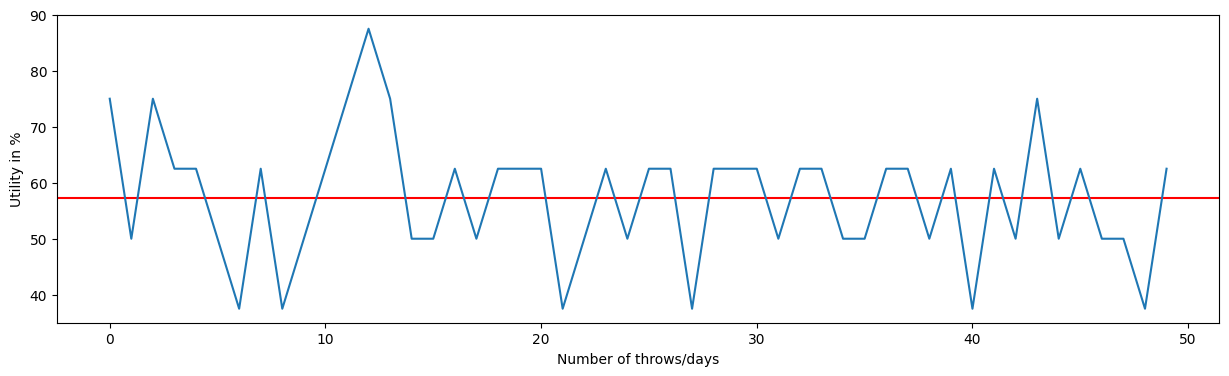

In [7]:
print("Quantum: The average occupancy or utility is {}% for {} balls and {} buckets".format(np.array(utility).mean()*100,N,N))


plt.figure(figsize=(15,4))
plt.ylabel("Utility in %")
plt.xlabel("Number of throws/days")
plt.axhline(y = np.array(utility).mean()*100, color = 'r', linestyle = '-')
plt.plot(np.array(utility)*100)
plt.show()

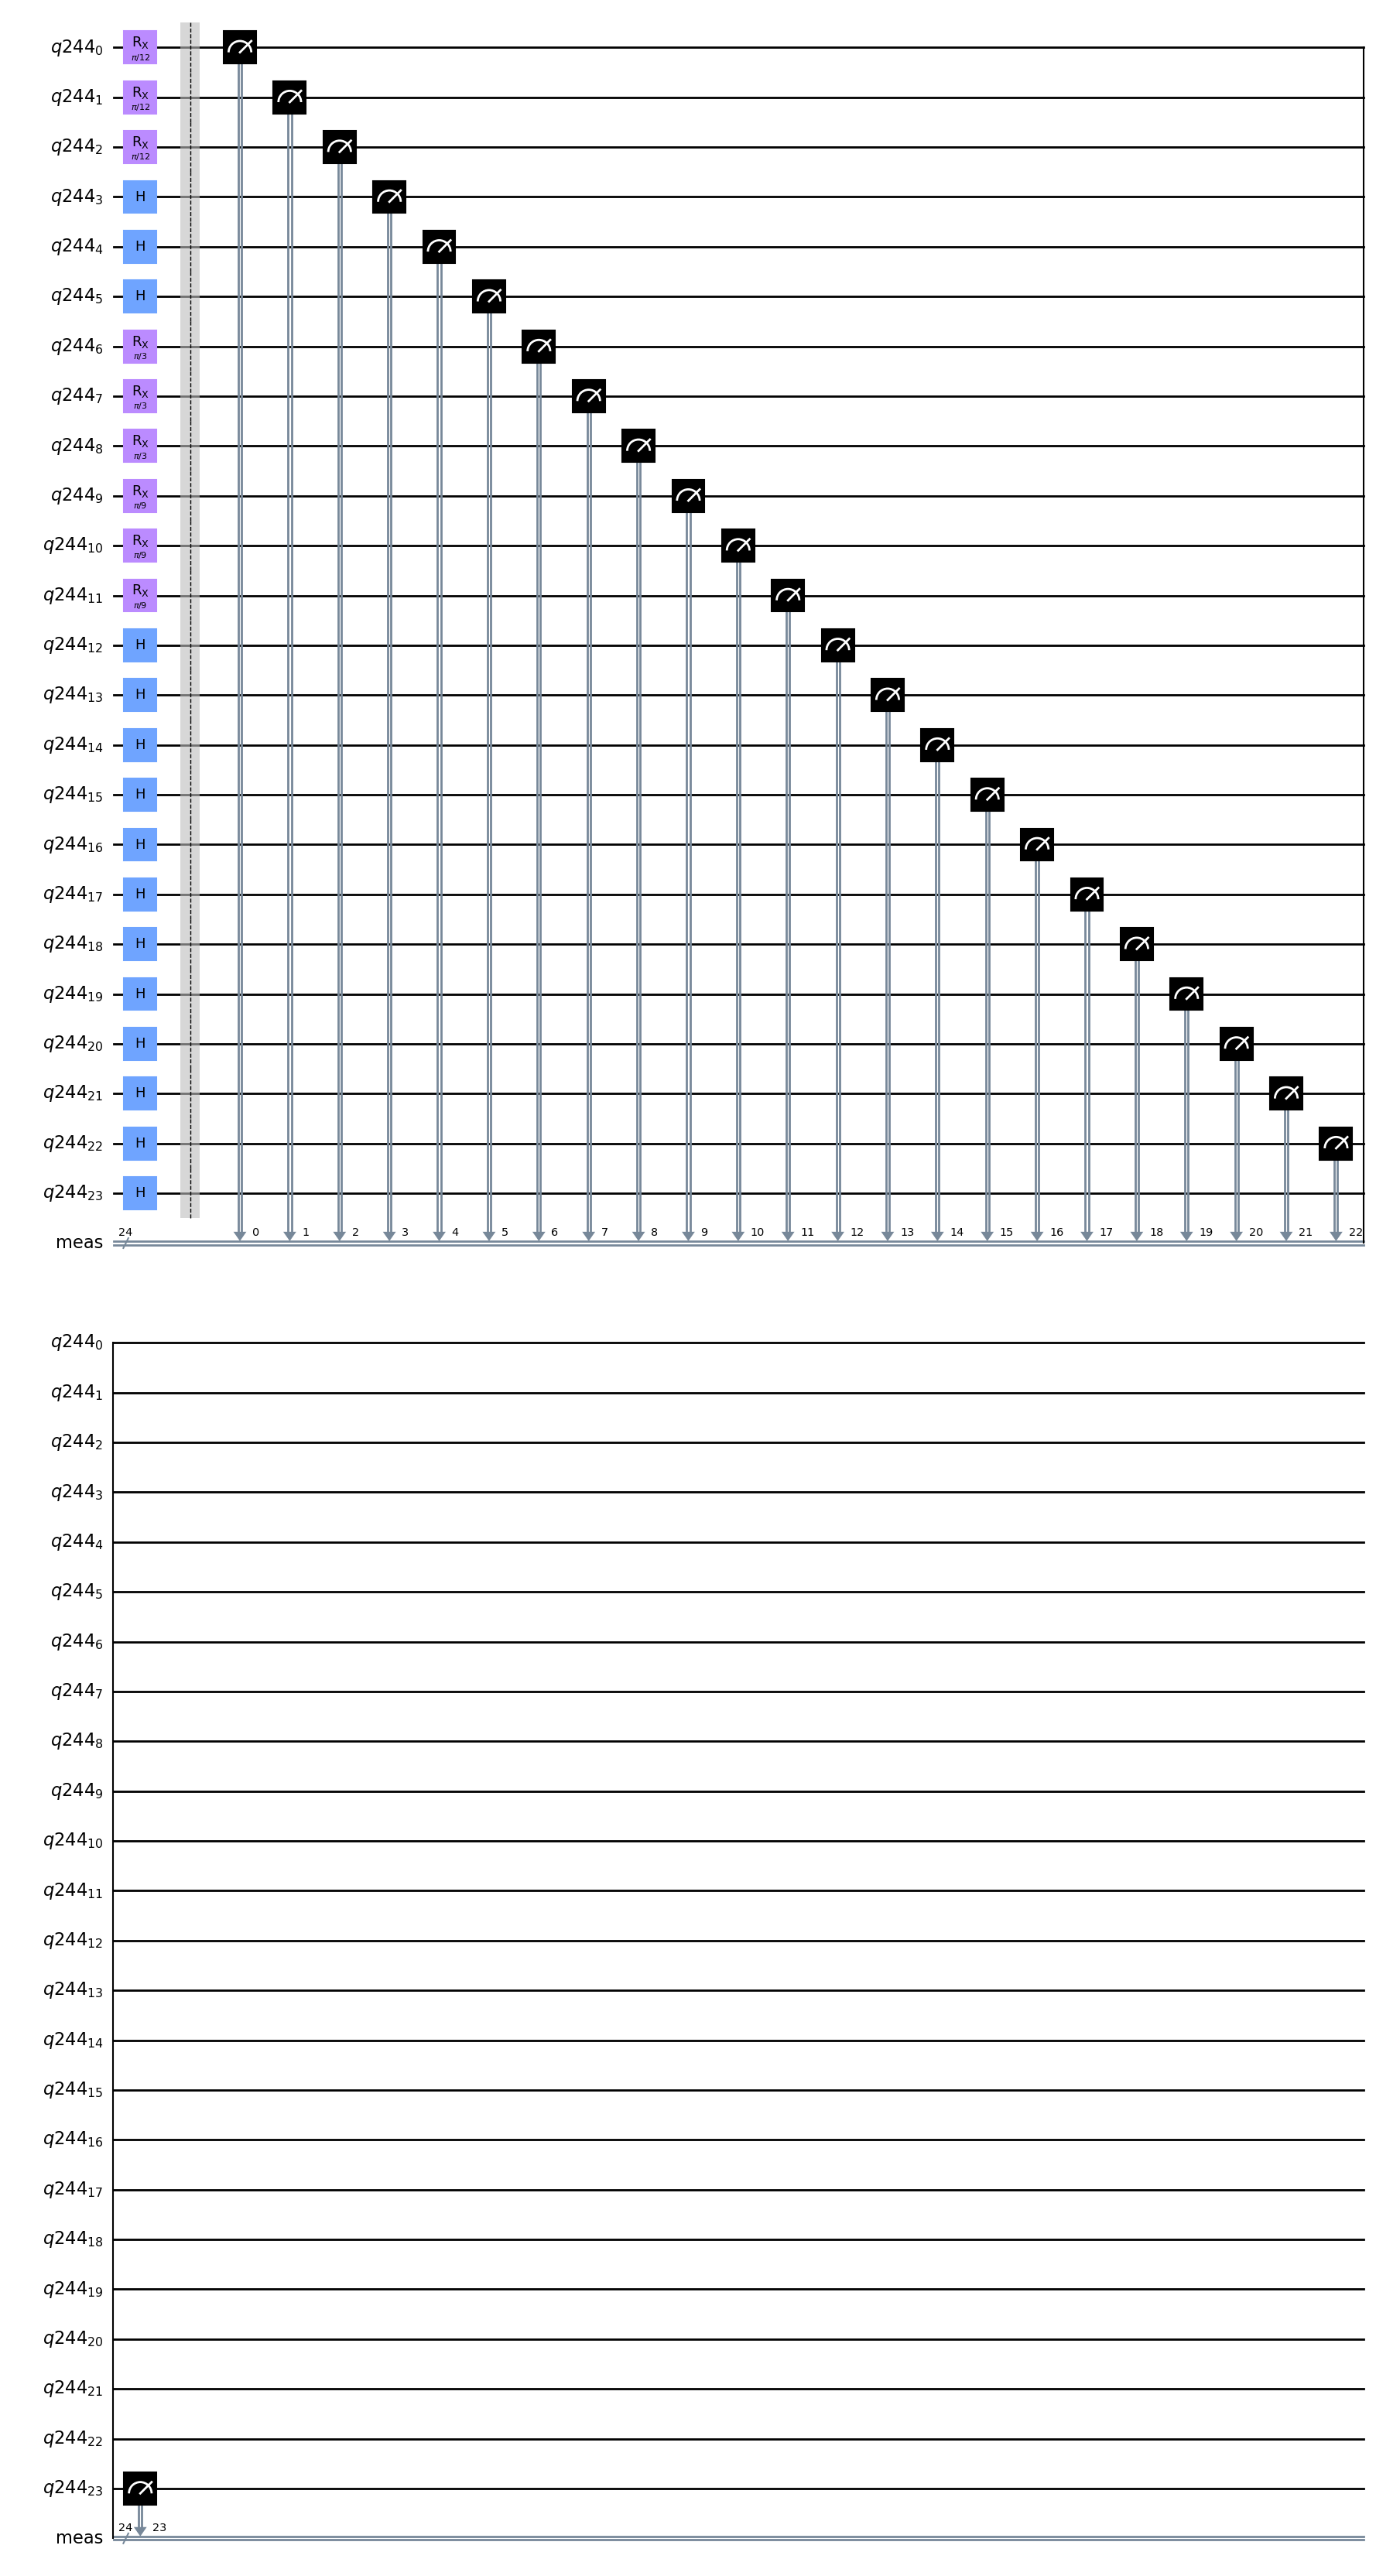

In [9]:
circuit.draw()